# Problem 1

![](https://cdn.discordapp.com/attachments/947918193924636695/1244531625975349288/Screenshot_20240527_150336.jpg?ex=665573e5&is=66542265&hm=27e96139fe66008fd096d092b98c635e98fbb2eaaf342d0c586e329c0274d4d9&)

# Problem 2

![](https://cdn.discordapp.com/attachments/947918193924636695/1244531626365685770/Screenshot_20240527_150347.jpg?ex=665573e6&is=66542266&hm=8dcac8b90c9559e8ad3424096d467c35413f47a338b401d2ee20640d2faf4714&)

# Problem 3

Iter: 0, Loss: -6.8436150550842285
Iter: 10, Loss: -6.892824649810791
Iter: 20, Loss: -6.92972993850708
Iter: 30, Loss: -6.9620280265808105
Iter: 40, Loss: -6.985325813293457
Iter: 50, Loss: -7.006398677825928
Iter: 60, Loss: -7.026517391204834
Iter: 70, Loss: -7.046076774597168
Iter: 80, Loss: -7.064619541168213
Iter: 90, Loss: -7.082091331481934
Iter: 100, Loss: -7.098620414733887
Iter: 110, Loss: -7.114864349365234
Iter: 120, Loss: -7.1299591064453125
Iter: 130, Loss: -7.144449234008789
Iter: 140, Loss: -7.158710956573486
Iter: 150, Loss: -7.1729865074157715
Iter: 160, Loss: -7.188165664672852
Iter: 170, Loss: -7.202929496765137
Iter: 180, Loss: -7.216187000274658
Iter: 190, Loss: -7.229316234588623
Iter: 200, Loss: -7.242006778717041
Iter: 210, Loss: -7.253932952880859
Iter: 220, Loss: -7.265429496765137
Iter: 230, Loss: -7.276333808898926
Iter: 240, Loss: -7.287834167480469
Iter: 250, Loss: -7.299662113189697
Iter: 260, Loss: -7.311108589172363
Iter: 270, Loss: -7.321900367736816


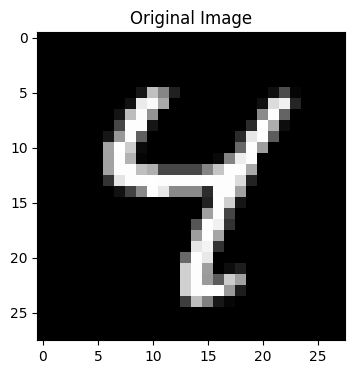

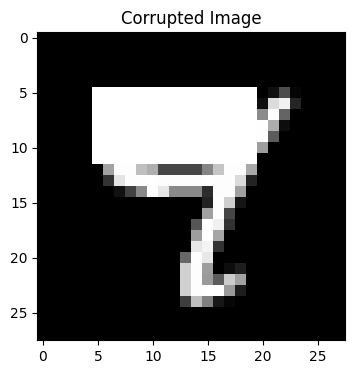

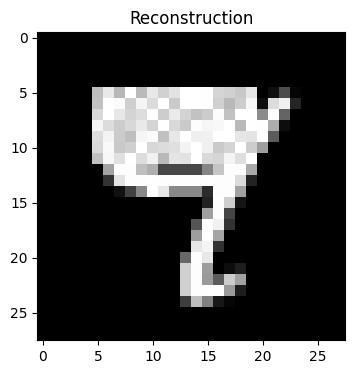

In [46]:
# flow_inpainting.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

import numpy as np
import matplotlib.pyplot as plt

batch_size = 128
(full_dim, mid_dim, hidden) = (1 * 28 * 28, 1000, 5)
lr = 1e-3
epochs = 100
device = torch.device("cpu")

############################################
# STEP 1: Define dataset and preprocessing #
############################################


class Logistic(torch.distributions.Distribution):
    def __init__(self):
        super(Logistic, self).__init__()

    def log_prob(self, x):
        return -(F.softplus(x) + F.softplus(-x))

    def sample(self, size):
        z = torch.distributions.Uniform(0., 1.).sample(size).to(device)
        return torch.log(z) - torch.log(1. - z)
    
####################################
# STEP 3: Implement Coupling Layer #
####################################

class Coupling(nn.Module):
    def __init__(self, in_out_dim, mid_dim, hidden, mask_config):
        super(Coupling, self).__init__()
        self.mask_config = mask_config
        
        self.in_block = nn.Sequential(nn.Linear(in_out_dim//2, mid_dim), nn.ReLU())
        self.mid_block = nn.ModuleList([nn.Sequential(nn.Linear(mid_dim, mid_dim), nn.ReLU())
                                                                 for _ in range(hidden - 1)])
        self.out_block = nn.Linear(mid_dim, in_out_dim//2)

    def forward(self, x, reverse=False):
        [B, W] = list(x.size())
        x = x.reshape((B, W//2, 2))
        if self.mask_config:
            on, off = x[:, :, 0], x[:, :, 1]
        else:
            off, on = x[:, :, 0], x[:, :, 1]

        off_ = self.in_block(off)
        for i in range(len(self.mid_block)):
            off_ = self.mid_block[i](off_)
        shift = self.out_block(off_)
        
        if reverse:
            on = on - shift
        else:
            on = on + shift

        if self.mask_config:
            x = torch.stack((on, off), dim=2)
        else:
            x = torch.stack((off, on), dim=2)
        return x.reshape((B, W))

class Scaling(nn.Module):
    def __init__(self, dim):
        super(Scaling, self).__init__()
        self.scale = nn.Parameter(torch.zeros((1, dim)), requires_grad=True)

    def forward(self, x, reverse=False):
        log_det_J = torch.sum(self.scale)
        if reverse:
            x = x * torch.exp(-self.scale)
        else:
            x = x * torch.exp(self.scale)
        return x, log_det_J
    
##########################
# STEP 4: Implement NICE #
##########################

class NICE(nn.Module):
    def __init__(self,in_out_dim, mid_dim, hidden, mask_config=1.0, coupling=4):
        super(NICE, self).__init__()
        self.prior = Logistic()
        self.in_out_dim = in_out_dim

        self.coupling = nn.ModuleList([
            Coupling(in_out_dim=in_out_dim, 
                     mid_dim=mid_dim, 
                     hidden=hidden, 
                     mask_config=(mask_config+i)%2) \
            for i in range(coupling)])
        
        self.scaling = Scaling(in_out_dim)

    def g(self, z):
        x, _ = self.scaling(z, reverse=True)
        for i in reversed(range(len(self.coupling))):
            x = self.coupling[i](x, reverse=True)
        return x

    def f(self, x):
        for i in range(len(self.coupling)):
            x = self.coupling[i](x)
        z, log_det_J = self.scaling(x)
        return z, log_det_J

    def log_prob(self, x):
        z, log_det_J = self.f(x)
        log_ll = torch.sum(self.prior.log_prob(z), dim=1)
        return log_ll + log_det_J

    def sample(self, size):
        z = self.prior.sample((size, self.in_out_dim)).to(device)
        return self.g(z)

    def forward(self, x):
        return self.log_prob(x)


# Load pre-trained NICE model onto CPU
model = NICE(in_out_dim=784, mid_dim=1000, hidden=5).to(device)
model.load_state_dict(torch.load('nice.pt',map_location=torch.device('cpu')))

# Since we do not update model, set requires_grad = False
model.requires_grad_(False)

# Get an MNIST image
testset = torchvision.datasets.MNIST(root='./', train=False, download=True, transform=torchvision.transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)
pass_count = 6
itr = iter(test_loader)
for _ in range(pass_count+1):
    image,_ = next(itr)
    
plt.figure(figsize = (4,4))
plt.title('Original Image')
plt.imshow(make_grid(image.squeeze().detach()).permute(1,2,0))
# plt.show()
plt.savefig('plt1.png')


# Create mask 
mask = torch.ones_like(image,dtype=torch.bool)
mask[:,:,5:12,5:20] = 0

# Partially corrupt the image
image[mask.logical_not()] = torch.ones_like(image[mask.logical_not()])
plt.figure(figsize = (4,4))
plt.title('Corrupted Image')
plt.imshow(make_grid(image.squeeze()).permute(1,2,0))
# plt.show()
plt.savefig('plt2.png')


lr = 1e-3
X = image.clone().requires_grad_(True)
optim = torch.optim.Adam([X], lr=lr)

for i in range(300):
    optim.zero_grad()
    loss = -torch.log(model(X.view(1, -1)))
    loss.backward()
    optim.step()
    X.data.clamp_(0, 1)
    X.data[mask] = image.data[mask]
    if i % 10 == 0:
        print(f'Iter: {i}, Loss: {loss.item()}')

recon = X
    
# Plot reconstruction
plt.figure(figsize = (4,4))
plt.title('Reconstruction')
plt.imshow(make_grid(recon.squeeze().detach()).permute(1,2,0))
# plt.show()
plt.savefig('plt3.png')


# Problem 4

![](https://cdn.discordapp.com/attachments/947918193924636695/1244531626780786688/Screenshot_20240527_150409.jpg?ex=665573e6&is=66542266&hm=f739e8982a2ea7b2963930ddd422deb74151defc221187fadacec29464995de3&)

# Problem 5

In [81]:
N = 6000
p = 18/37; q = 0.55
K = 600
X = np.random.binomial(1, q, (N, K))
cnt = np.sum(X, axis=1)
W = ((p/q) / ((1-p)/(1-q)))**cnt * ((1-p)/(1-q))**K
win = np.zeros(N)
for idx, arr in enumerate(X):
  bal = 100
  for i in arr:
    if i == 1: bal += 1
    else: bal -= 1
    if bal == 0: break
    if bal == 200: break
  if bal == 200: win[idx] = 1
print(np.sum(win * W) / np.sum(W))

1.8821957079327503e-06


# Problem 6

## (a)

In [107]:
iter = 1000
mu = 0; tau = 0
lr = 1e-3; B = 100

for _ in range(iter):
  sig = np.exp(tau)
  X = np.random.normal(mu, sig, B)
  grad_mu = np.mean(
    X*np.sin(X) * ((X - mu)/sig**2) + (mu - 1)
  ) 
  grad_sig = np.mean(
    X*np.sin(X) * (((X - mu)**2/sig**3) - 1/sig) + 1 - 1/sig
  ) 
  grad_tau = grad_sig * sig
  mu -= lr * grad_mu
  tau -= lr * grad_tau

print(mu, np.exp(tau))

0.42845305009510465 0.7011747441809559


## (b)

In [108]:
iter = 1000
mu = 0; tau = 0
lr = 1e-3; B = 100

for _ in range(iter):
  sig = np.exp(tau)
  Y = np.random.normal(0, 1, B)
  grad_mu = np.mean(
    np.sin(Y * sig + mu) + (Y * sig + mu) * np.cos(Y * sig + mu) + (mu - 1)
  )
  grad_sig = np.mean(
    Y * np.sin(Y * sig + mu) + (Y * sig + mu) * Y * np.cos(Y * sig + mu) + 1 - 1/sig
  )
  grad_tau = grad_sig * sig
  mu -= lr * grad_mu
  tau -= lr * grad_tau

print(mu, np.exp(tau))

0.4271111348872143 0.7012239561826565
